# Chapter 6 - Linear Model Selection and Regularization

- [Model Selection Methods](https://xavierbourretsicotte.github.io/subset_selection.html#Comparing-models:-AIC,-BIC,-Mallows'CP)
    - [Best Subset Selection](#subset) 
    - [Forward Stepwise Selection](#forward) 
    - [Comparing models: AIC, BIC, Mallows'CP](#compare)
- [Lab 2: Ridge Regression](#6.6.1-Ridge-Regression)
- [Lab 2: The Lasso](#6.6.2-The-Lasso)
- [Lab 3: Principal Components Regression](#6.7.1-Principal-Components-Regression)
- [Lab 3: Partial Least Squares](#6.7.2-Partial-Least-Squares)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import itertools
import time
import statsmodels.api as sm
#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-white')


# Model Selection Methods

## Dataset
The credit dataset is a use case for linear regression where some predictors are qualitative.

In [2]:
credit = pd.read_csv('Data/Credit.csv', usecols=list(range(1,12)))
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580


### Encoding qualitative data

In [3]:
credit = pd.get_dummies(credit, columns = ['Gender', 'Student','Married','Ethnicity'],drop_first = True)
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,11,333,0,0,1,0,1
1,106.025,6645,483,3,82,15,903,1,1,1,1,0
2,104.593,7075,514,4,71,11,580,0,0,0,1,0


<a id='subset'></a>
## Best Subset Selection
To perform best selection, we fit separate models for each possible combination of the n predictors and then select the best subset. That is we fit:

- All models that contains exactly one predictor
- All models that contain 2 predictors at the second step
- All models that contain 3 predictors at the thrid step
- ...
- Until reaching the end point where all n predictors are included in the model

This results in 2n possibilities as this is a power set problem. In our case there are 2^11=2048 possible combinations

### Helper function for fitting linear regression (Sklearn)

In [4]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

### Implementing Best subset selection (using itertools.combinations)

In [5]:
#Initialization variables
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11

In [6]:
X

,Income,Limit,Rating,Cards,Age,Education,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,11,0,0,1,0,1
1,106.025,6645,483,3,82,15,1,1,1,1,0
2,104.593,7075,514,4,71,11,0,0,0,1,0
3,148.924,9504,681,3,36,11,1,0,0,1,0
4,55.882,4897,357,2,68,16,0,0,1,0,1
5,80.180,8047,569,4,77,10,0,0,0,0,1
6,20.996,3388,259,2,37,12,1,0,0,0,0
7,71.408,7114,512,2,87,9,0,0,0,1,0
8,15.125,3300,266,5,66,13,1,0,0,0,1
9,71.061,6819,491,3,41,19,1,1,1,0,0


In [7]:
len(X.columns) + 1

12

In [8]:
tnrange(1,len(X.columns) + 1, desc = 'Loop...')

Loop...:   0%|<bar/>| 0/11 [00:00<?, ?it/s]

In [10]:
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):
    for combo in itertools.combinations(X.columns, k):
        ; #print(combo)

In [11]:
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
# tqdm.tnrange : progress bar
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})
df.head(16)

,numb_features,RSS,R_squared,features
0,1,6.620874e+07,0.214977,"(Income,)"
1,1,2.171566e+07,0.742522,"(Limit,)"
2,1,2.143512e+07,0.745848,"(Rating,)"
3,1,8.370950e+07,0.007475,"(Cards,)"
4,1,8.433963e+07,0.000003,"(Age,)"
5,1,8.433443e+07,0.000065,"(Education,)"
6,1,8.430102e+07,0.000461,"(Gender_Female,)"
7,1,7.868154e+07,0.067090,"(Student_Yes,)"
8,1,8.433720e+07,0.000032,"(Married_Yes,)"
9,1,8.433179e+07,0.000096,"(Ethnicity_Asian,)"


### Finding the best subsets for each number of features
Using the smallest RSS value, or the largest R_squared value



https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

In [12]:
print(pd.DataFrame({'name':['a','b','a','b'], 'height':[100,200,300,400]}).groupby('name').mean())

      height
name        
a        200
b        300


In [14]:
print(pd.DataFrame({'name':['a','b','a','b'], 'height':[100,200,300,400]}).groupby('name').transform('sum'))

   height
0     400
1     600
2     400
3     600


In [18]:
df.shape, df

((2047, 4),       numb_features           RSS  R_squared  \
 0                 1  6.620874e+07   0.214977   
 1                 1  2.171566e+07   0.742522   
 2                 1  2.143512e+07   0.745848   
 3                 1  8.370950e+07   0.007475   
 4                 1  8.433963e+07   0.000003   
 5                 1  8.433443e+07   0.000065   
 6                 1  8.430102e+07   0.000461   
 7                 1  7.868154e+07   0.067090   
 8                 1  8.433720e+07   0.000032   
 9                 1  8.433179e+07   0.000096   
 10                1  8.433900e+07   0.000011   
 11                2  1.087083e+07   0.871107   
 12                2  1.053254e+07   0.875118   
 13                2  6.544847e+07   0.223992   
 14                2  6.565932e+07   0.221492   
 15                2  6.620682e+07   0.215000   
 16                2  6.614972e+07   0.215677   
 17                2  6.093905e+07   0.277459   
 18                2  6.616711e+07   0.215471   
 19      

In [19]:
df.groupby('numb_features')['RSS']

In [20]:
df.groupby('numb_features')['RSS'].transform(min)

0       2.143512e+07
1       2.143512e+07
2       2.143512e+07
3       2.143512e+07
4       2.143512e+07
5       2.143512e+07
6       2.143512e+07
7       2.143512e+07
8       2.143512e+07
9       2.143512e+07
10      2.143512e+07
11      1.053254e+07
12      1.053254e+07
13      1.053254e+07
14      1.053254e+07
15      1.053254e+07
16      1.053254e+07
17      1.053254e+07
18      1.053254e+07
19      1.053254e+07
20      1.053254e+07
21      1.053254e+07
22      1.053254e+07
23      1.053254e+07
24      1.053254e+07
25      1.053254e+07
26      1.053254e+07
27      1.053254e+07
28      1.053254e+07
29      1.053254e+07
            ...     
2017    3.798367e+06
2018    3.798367e+06
2019    3.798367e+06
2020    3.798367e+06
2021    3.798367e+06
2022    3.798367e+06
2023    3.798367e+06
2024    3.798367e+06
2025    3.798367e+06
2026    3.798367e+06
2027    3.798367e+06
2028    3.798367e+06
2029    3.798367e+06
2030    3.798367e+06
2031    3.798367e+06
2032    3.798367e+06
2033    3.798

In [21]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(3))
display(df_max.head(3))

,numb_features,RSS,R_squared,features
2,1,2.143512e+07,0.745848,"(Rating,)"
12,2,1.053254e+07,0.875118,"(Income, Rating)"
79,3,4.227219e+06,0.949879,"(Income, Rating, Student_Yes)"


,numb_features,RSS,R_squared,features
2,1,2.143512e+07,0.745848,"(Rating,)"
12,2,1.053254e+07,0.875118,"(Income, Rating)"
79,3,4.227219e+06,0.949879,"(Income, Rating, Student_Yes)"


### Adding columns to the dataframe with RSS and R squared values of the best subset

In [22]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,6.620874e+07,0.214977,"(Income,)",2.143512e+07,0.745848
1,1,2.171566e+07,0.742522,"(Limit,)",2.143512e+07,0.745848
2,1,2.143512e+07,0.745848,"(Rating,)",2.143512e+07,0.745848
3,1,8.370950e+07,0.007475,"(Cards,)",2.143512e+07,0.745848
4,1,8.433963e+07,0.000003,"(Age,)",2.143512e+07,0.745848


### Plotting the best subset selection process

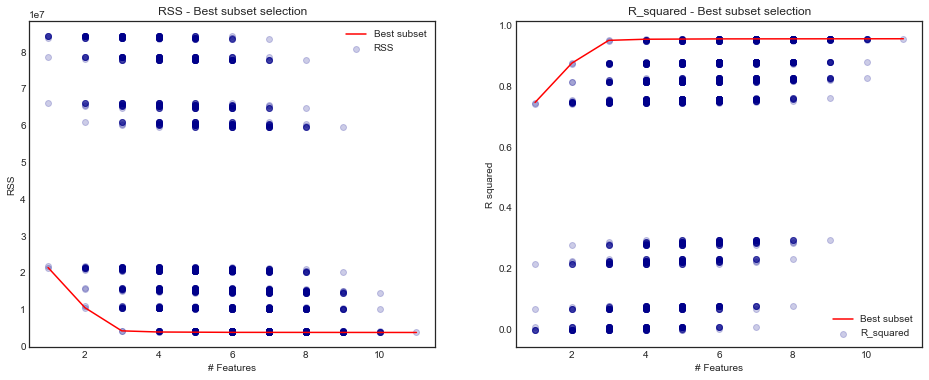

In [23]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue')
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue')
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

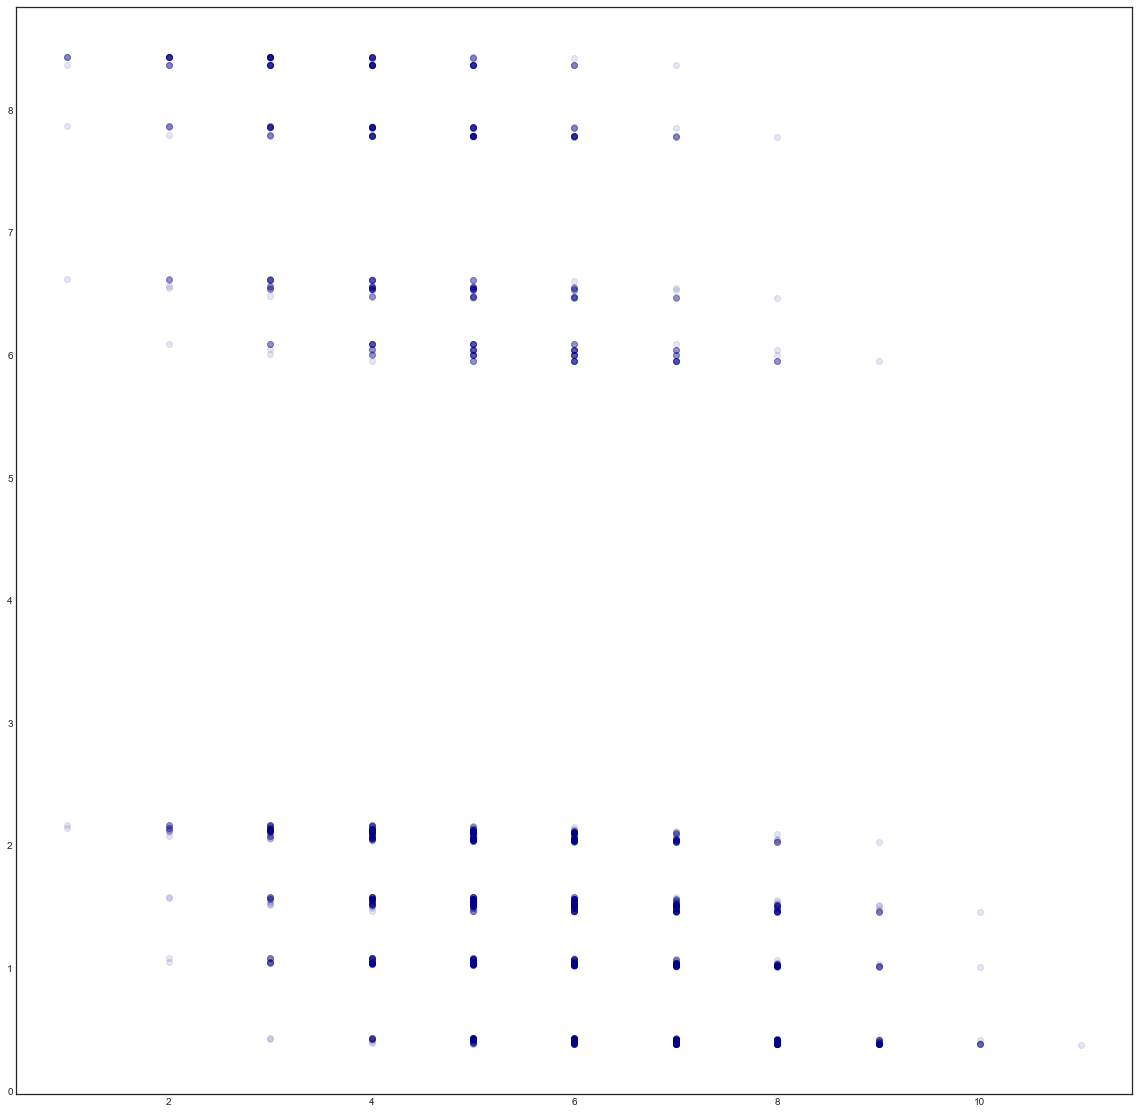

In [31]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df.numb_features, df.RSS/10000000, alpha = .1, color = 'darkblue')
plt.show()

<a id='forward'></a>
## Forward stepwise selection
For computational reasons, the best subset cannot be applied for any large n due to the 2^n complexity. 

Forward Stepwise begins with a model containing no predictors, and then adds predictors to the model, one at the time. 

At each step, the variable that gives the greatest additional improvement to the fit is added to the model.

### Algorithm
Let M0 denote the null model which contains no predictors

- For k=1,2,...,n−1
    - Consider all n−k models that augment the predictors in Mk with one additional predictor
    - Choose the 'best' among these n−k models, and call it Mk+1
- Select the single best model among M0,M1,...,Mn using cross validated predicton error, Cp, BIC, adjusted R2 or any other method.

In [32]:
#Initialization variables
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf    
    for combo in itertools.combinations(remaining_features,1):
        RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 
        if RSS[0] < best_RSS:
            best_RSS = RSS[0]
            best_R_squared = RSS[1] 
            best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

### Displaying results of the first 4 steps

In [33]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['Rating'], 21435122.0),
 (2, ['Rating', 'Income'], 10532541.0),
 (3, ['Rating', 'Income', 'Student_Yes'], 4227219.0),
 (4, ['Rating', 'Income', 'Student_Yes', 'Limit'], 4032502.0)]

<a id='compare'></a>
## Comparing models: AIC, BIC, Mallows'CP
The training set Mean Squared Error (MSE) is generally an underestimate of the test MSE. This is because when we fit a model to the training data using least squares, we specifically estimate the regression coefficients such that the training RSS is minimized. In particular, the training RSS decreases as we add more features to the model, but the test error may not. Therefore the training RSS and $R^2$ may not be used for selecting the best model unless we adjust for this underestimation. 

###  Theoretical justification
$C_p$, AIC, BIC all have rigorous theoretical justification that rely on asymptotic arguments, i.e. when the sample size $m$ grows very large, whereas the adjusted $R^2$, although quite intuitive, is not as well motivated in statistical theory. 

### Combining forward stepwise results into a new DataFrame

In [35]:
df1 = pd.concat([pd.DataFrame({'features':features_list}), pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

### Computing the C_p, AIC, BIC and R-square adjusted
### Estimation of $\hat\sigma^2$
Using the RSS of the full model with $p$ features, (i.e.the smallest RSS) we estimate $\hat\sigma^2$ as: $$ \hat\sigma^2 = \frac{RSS}{m - p -1} $$

In [36]:
# sample number
m = len(Y)
# predictor number
p = 11
hat_sigma_squared = min(df1['RSS']) / (m - p -1)

In [38]:
hat_sigma_squared

9759.613893499438

### Mallow's $C_p$
Mallow's $C_p$ is named after Colin Lingwood Mallows and is defined as: $$ C_p = \frac{1}{m} (RSS + 2d\hat\sigma^2)$$ where $\hat\sigma^2$ is an estimate of the variance of the error $\epsilon$ associated with each response measurement. Typically $\hat\sigma^2$ is estimated using the full model containing all predictors. Essentially,the $C_p$ statistic adds a penalty of $2d\hat\sigma^2$ to the training RSS in order to adjust for the fact that the training error tends to underestimate the test error. Clearly, the penalty increases as the number of predictors in the model increases, and this is intended to adjust for the corresponding decrease in training RSS. It can be shown that if $\hat\sigma^2$ is an unbiased estimate of $\sigma^2$ then $C_p$ is an unbiased estimate of the test MSE, so we choose the model with the smallest $C_p$. 

In [39]:
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )

In [40]:
df1

,features,RSS,R_squared,numb_features,C_p
1,[Rating],2.143512e+07,0.745848,1,53636.603151
2,"[Rating, Income]",1.053254e+07,0.875118,2,26428.949364
3,"[Rating, Income, Student_Yes]",4.227219e+06,0.949879,3,10714.442485
4,"[Rating, Income, Student_Yes, Limit]",4.032502e+06,0.952188,4,10276.446437
5,"[Rating, Income, Student_Yes, Limit, Cards]",3.866091e+06,0.954161,5,9909.218362
6,"[Rating, Income, Student_Yes, Limit, Cards, Age]",3.821620e+06,0.954688,6,9846.837591
7,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.810759e+06,0.954817,7,9868.483418
8,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.804746e+06,0.954888,8,9902.248962
9,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.798367e+06,0.954964,9,9935.100415
10,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.791345e+06,0.955047,10,9966.344067


### Akaike's Information Criteria (AIC)
The AIC criterion is defiend for a large class of models fit by maximum likelihood. In the case of a linear model with Gaussian errors, MLE and least squares are the same thing and the AIC is given by $$ AIC = \frac{1}{m\hat \sigma^2} (RSS + 2d\hat\sigma^2)$$ 

In [41]:
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )

### Bayesian Information Criteria (BIC)
BIC is derived from a Bayesian point of view, and looks similar to the $C_p$ and $AIC$ - it is defined (up to irrelevant constants) as: $$ BIC = \frac{1}{m\hat \sigma^2} (RSS + \log(m) d \hat\sigma^2)$$ Like $C_p$ and AIC, the BIC will tend to take small values for a model with low test error. 

In [42]:
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )

### Adjusted $R^2$
Since the $R^2$ always increases as more variables are added, the adjusted $R^2$ accounts for that fact and introduces a penalty. The intuition is that once all the correct variables have been included in the model,additional _noise_ variables will lead to a very small decrase in RSS, but an increase in $k$ and hence will decrease the adjusted $R^2$. In effect, we pay a price for the inclusion of unnecessary variables in the model. $$ R_{a}^2 = 1 - \frac{RSS / (m - k -1)}{TSS / (m - 1)} = 1 - (1 - R^2) \frac{m - 1}{m - k - 1} $$ 

In [43]:
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))

In [44]:
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[Rating],2.143512e+07,0.745848,1,53636.603151,5.495771,5.505750,0.745210
2,"[Rating, Income]",1.053254e+07,0.875118,2,26428.949364,2.707991,2.727949,0.874489
3,"[Rating, Income, Student_Yes]",4.227219e+06,0.949879,3,10714.442485,1.097835,1.127771,0.949499
4,"[Rating, Income, Student_Yes, Limit]",4.032502e+06,0.952188,4,10276.446437,1.052956,1.092871,0.951703
5,"[Rating, Income, Student_Yes, Limit, Cards]",3.866091e+06,0.954161,5,9909.218362,1.015329,1.065222,0.953579
6,"[Rating, Income, Student_Yes, Limit, Cards, Age]",3.821620e+06,0.954688,6,9846.837591,1.008937,1.068809,0.953996
7,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.810759e+06,0.954817,7,9868.483418,1.011155,1.081006,0.954010
8,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.804746e+06,0.954888,8,9902.248962,1.014615,1.094444,0.953965
9,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.798367e+06,0.954964,9,9935.100415,1.017981,1.107789,0.953924
10,"[Rating, Income, Student_Yes, Limit, Cards, Ag...",3.791345e+06,0.955047,10,9966.344067,1.021182,1.120969,0.953891


### Find a best model based on a Adjusted $R^2$ 

In [45]:
print(df1['R_squared_adj'].idxmax())
print(df1['R_squared_adj'].max())

7
0.9540098163629882


### Plotting the computed values as a function of number of features

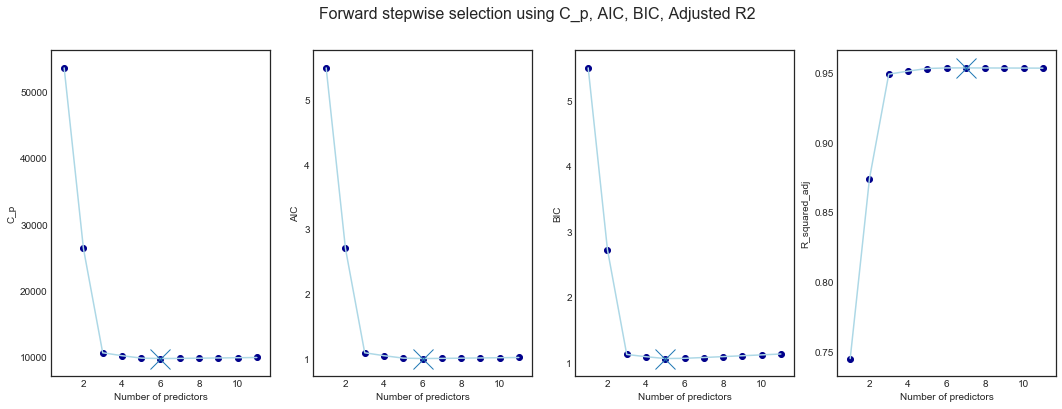

In [46]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Forward stepwise selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

# Lab 2

In [47]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
df = pd.read_csv('Data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [23]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [48]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0           1            1   

                   NewLeague_N  
Player                          
-Alan Ashby             

In [49]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


In [50]:
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


#### I executed the R code and downloaded the exact same training/test sets used in the book.

In [51]:
X_train = pd.read_csv('Data/Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Data/Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Data/Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Data/Hitters_y_test.csv', index_col=0)

### 6.6.1 Ridge Regression

### Scikit-learn

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:
### $$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to
### $$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$
The __sklearn Ridge()__ function optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$

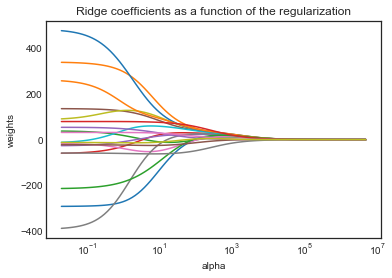

In [52]:
alphas = 5**np.linspace(10,-2,100)*0.5 

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### Alpha = 4

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [54]:
ridge2 = Ridge(alpha=4)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
mean_squared_error(y_test, pred)

97383.68965102115

In [55]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat         -161.784058
Hits           118.911404
HmRun           52.645719
Runs           -43.295947
RBI             37.339573
Walks          138.214992
Years         -106.916784
CAtBat         -21.080864
CHits          115.933862
CHmRun         -17.949420
CRuns          239.723217
CRBI           -17.945273
CWalks         -59.754770
PutOuts         21.752383
Assists        -68.676906
Errors          89.610291
League_N        31.048268
Division_W     -13.553466
NewLeague_N      4.350305
dtype: float64

#### Alpha = $10^{10}$  (Alpha graph & find optimal alpha)
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [56]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

193253.09741651407

In [57]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          2.291553e-06
Hits           2.428111e-06
HmRun          2.051677e-06
Runs           2.372252e-06
RBI            2.538921e-06
Walks          2.974270e-06
Years          1.572334e-06
CAtBat         2.507043e-06
CHits          2.666936e-06
CHmRun         2.280416e-06
CRuns          2.839982e-06
CRBI           2.526355e-06
CWalks         2.544939e-06
PutOuts        4.880225e-07
Assists       -1.149268e-06
Errors         2.067779e-06
League_N       5.324293e-07
Division_W     5.051366e-07
NewLeague_N    5.291999e-07
dtype: float64

#### Training mse with different alpha value

Text(0.5, 1.0, 'Training mse with different alpha')

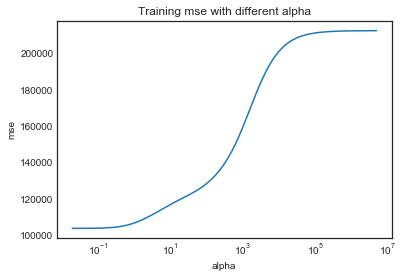

In [58]:
alphas = 5**np.linspace(10,-2,100)*0.5 
mse = []
for a in alphas:
    ridge2 = Ridge(alpha=a)
    ridge2.fit(scaler.transform(X_train), y_train)
    pred = ridge2.predict(scaler.transform(X_train))
    mse.append(mean_squared_error(y_train, pred))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha')

#### Training mse with different alpha value (Cross validation)

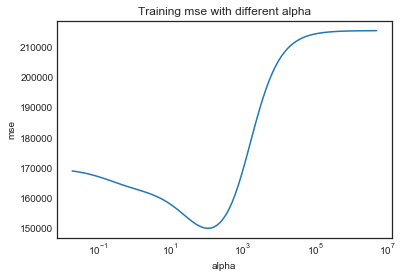

In [59]:
alphas = 5**np.linspace(10,-2,100)*0.5 
mse = []
# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)
for a in alphas:
    ridge2 = Ridge(alpha=a)
    mse.append(-1*cross_val_score(ridge2, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean())

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

#### Test mse with different alpha value

Text(0.5, 1.0, 'Test mse with different alpha')

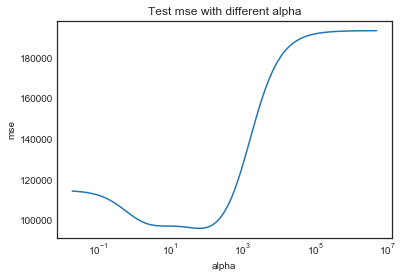

In [60]:
alphas = 5**np.linspace(10,-2,100)*0.5 
mse = []
for a in alphas:
    ridge2 = Ridge(alpha=a)
    ridge2.fit(scaler.transform(X_train), y_train)
    pred = ridge2.predict(scaler.transform(X_test))
    mse.append(mean_squared_error(y_test, pred))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()) 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Test mse with different alpha')

#### Compute the regularization path using RidgeCV
Ridge regression with built-in cross-validation.

Default cross validation method is "Generalized Cross-Validation" (efficient Leave-One-Out).

In [37]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([4.88281250e+06, 4.01741235e+06, 3.30539050e+06, 2.71956308e+06,
       2.23756418e+06, 1.84099184e+06, 1.51470558e+06, 1.24624833e+06,
       1.02537082e+06, 8.43640297e+05, 6.94118595e+05, 5.71097214e+05,
       4.69879399e+05, 3.86600818e+05, 3.18082028e+05, 2.61707094e+05,
       2.15323712e+05, 1.77161040e+05, 1.45762089e+05, 1.19928098e+05,
       9.86727677e+04, 8.11846033e+0...
       3.73150948e-01, 3.07015931e-01, 2.52602285e-01, 2.07832585e-01,
       1.70997595e-01, 1.40691016e-01, 1.15755791e-01, 9.52399351e-02,
       7.83601852e-02, 6.44721001e-02, 5.30454551e-02, 4.36439996e-02,
       3.59088012e-02, 2.95445425e-02, 2.43082465e-02, 2.00000000e-02]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring='neg_mean_squared_error', store_cv_values=False)

In [38]:
# Optimal alpha that RidgeCV found
ridgecv.alpha_

106.87349666729351

In [39]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))
# Compare this mse value with an above graph (MSE with different alpha)

97171.90036529172

In [40]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat           6.527403
Hits           22.754323
HmRun          19.213875
Runs           20.029787
RBI            21.072806
Walks          57.407651
Years          -5.790283
CAtBat         20.637323
CHits          29.977244
CHmRun         14.050638
CRuns          37.018236
CRBI           20.284659
CWalks         24.526594
PutOuts        16.522197
Assists       -45.652512
Errors         56.322520
League_N        6.000427
Division_W     -0.571164
NewLeague_N    11.210351
dtype: float64

### 6.6.2 The Lasso

### Scikit-learn



For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

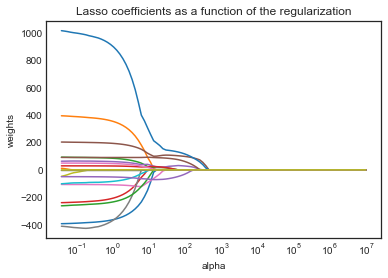

In [41]:
# Lasso in Scikit-learn has a max iteration since it uses "Coordinate descent solver"
lasso = Lasso(max_iter=10000)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

#### Training mse with different alpha value

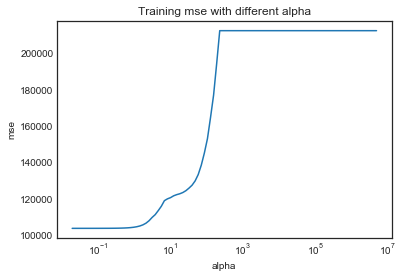

In [42]:
lasso = Lasso(max_iter=10000)
mse = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    mse.append(mean_squared_error(y_train, lasso.predict(scale(X_train))))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

#### Training mse with different alpha value (Cross validataion)

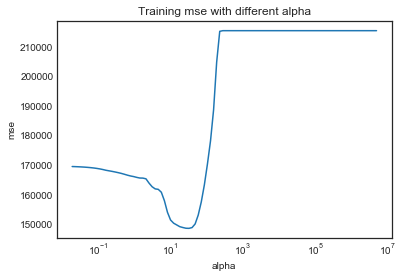

In [43]:
lasso = Lasso(max_iter=10000)
mse = []
# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)
for a in alphas:
    lasso.set_params(alpha=a)
    mse.append(-1*cross_val_score(lasso, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean())

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

#### Test mse with different alpha value

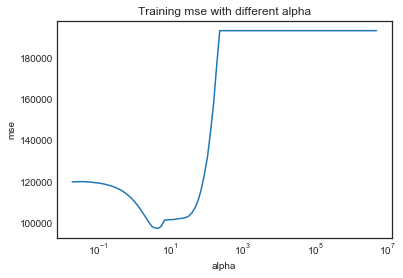

In [44]:
lasso = Lasso(max_iter=10000)
mse = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)  
    mse.append(mean_squared_error(y_test, lasso.predict(scale(X_test))))

ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.title('Training mse with different alpha');

#### Compute the regularization path using LassoCV
Lasso regression with built-in cross-validation.

Alphas are set automatically

In [45]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.as_matrix().ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [46]:
lassocv.alpha_

30.01382256446427

In [47]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

102924.90954696965

In [48]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             0.000000
HmRun            2.154219
Runs             0.000000
RBI             30.835560
Walks          104.071528
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns          132.858095
CRBI             0.000000
CWalks           0.000000
PutOuts          1.896185
Assists        -51.058752
Errors          76.779641
League_N         0.000000
Division_W       0.000000
NewLeague_N      0.000000
dtype: float64

# Lab 3

### 6.7.1 Principal Components Regression

Scikit-klearn does not have an implementation of PCA and regression combined like the 'pls' package in R.
https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf

In [61]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

In [71]:
X.shape 

(263, 19)

In [73]:
X.head(4)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1


In [75]:
scale(X)

array([[-0.6029005 , -0.59567545, -0.5285512 , ...,  1.05875764,
         0.98116592,  1.07505242],
       [ 0.51254171,  0.49225957,  0.72996619, ..., -0.94450322,
         0.98116592, -0.9301872 ],
       [ 0.62816682,  0.73648988,  0.95878753, ...,  1.05875764,
        -1.01919561,  1.07505242],
       ...,
       [ 0.48533581,  0.40344855, -0.98619389, ..., -0.94450322,
         0.98116592, -0.9301872 ],
       [ 1.15188054,  0.80309815, -0.29972986, ..., -0.94450322,
        -1.01919561, -0.9301872 ],
       [ 1.54636621,  1.38036979, -0.29972986, ..., -0.94450322,
         0.98116592, -0.9301872 ]])

In [76]:
X_reduced

array([[-9.64871922e-03,  1.87052198e+00,  1.26514521e+00, ...,
         8.02161532e-02,  3.81397452e-02, -1.92500795e-02],
       [ 4.11433695e-01, -2.42942190e+00, -9.09193165e-01, ...,
         4.43434707e-02,  1.48342246e-02, -3.39451856e-03],
       [ 3.46682196e+00,  8.25946988e-01,  5.55469466e-01, ...,
        -2.18282868e-01,  3.78251162e-02, -6.65007373e-02],
       ...,
       [-1.09460888e+00, -7.51385751e-01, -9.35936894e-01, ...,
        -7.87381606e-02,  6.72009318e-02,  1.31936353e-02],
       [ 1.97768180e+00, -2.18451741e+00, -2.82011929e-01, ...,
        -1.44073449e-02,  2.29207125e-02, -1.05296972e-02],
       [ 1.83300238e+00, -3.01096659e-01, -1.05532275e+00, ...,
        -3.02569189e-01, -7.55286689e-02, -4.05988737e-02]])

The above loadings are the same as in R.

In [80]:
print(X_reduced.shape)

(263, 19)


In [81]:
pd.DataFrame(X_reduced)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.009649,1.870522,1.265145,-0.935481,1.109636,1.211972,-0.065146,-0.098249,-0.252423,-0.637101,0.459341,0.615860,-0.478088,0.388407,0.063596,0.144790,0.080216,0.038140,-0.019250
1,0.411434,-2.429422,-0.909193,-0.264212,1.232031,1.826617,0.359893,-1.199383,-0.371820,0.015215,0.176235,0.080529,0.403483,-0.019386,0.065149,0.161064,0.044343,0.014834,-0.003395
2,3.466822,0.825947,0.555469,-1.616726,-0.857488,-1.028712,-0.999385,0.844247,0.197379,0.770490,0.055645,0.104938,0.021605,-0.376197,0.234291,0.011526,-0.218283,0.037825,-0.066501
3,-2.558317,-0.230984,0.519642,-2.176251,-0.820301,1.491696,-0.276141,0.207094,0.414956,0.136842,-0.085375,-0.146217,0.142172,0.028975,0.042459,0.053043,-0.044443,0.010360,-0.013582
4,1.027702,-1.573537,1.331382,3.494004,0.983427,0.513675,0.140456,0.989707,-0.661933,-0.217565,0.111259,0.191244,-0.302426,-0.090770,0.043811,0.012300,-0.050593,0.126036,-0.071035
5,-3.980657,1.507279,-0.155479,0.369840,-1.209334,0.033514,0.013007,-0.540315,0.121838,0.411966,-1.198707,0.538882,0.106017,-0.238849,0.193108,-0.057444,0.052532,-0.024036,0.025065
6,-3.451719,0.599989,-0.626476,1.999776,0.807026,0.205971,-0.056137,0.395305,0.719654,0.421149,0.039300,-0.022136,0.178050,0.172087,-0.087011,-0.048078,-0.014070,-0.028050,0.000720
7,-3.432380,0.113542,1.999750,0.767813,1.016092,-0.272797,-1.204274,-0.098152,0.035413,0.359129,-0.010706,-0.201662,0.115068,0.284426,0.006564,0.064950,-0.059816,-0.067180,-0.004802
8,3.899707,1.947870,-1.820475,-0.026713,-1.137128,-0.821045,0.314217,-1.192292,0.444240,0.510195,0.217092,0.221224,0.130075,0.644068,-0.005987,-0.108769,0.131745,-0.057934,-0.022755
9,3.174812,-2.392365,0.794468,2.569006,-0.947328,-0.061251,-0.375009,-0.425686,-0.065025,-0.498544,-0.533286,-0.717679,-0.283230,-0.272698,-0.290593,-0.094599,0.054802,-0.028549,0.027711


In [62]:
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


,0,1,2,3,4,5
0,-0.009649,1.870522,1.265145,-0.935481,1.109636,1.211972
1,0.411434,-2.429422,-0.909193,-0.264212,1.232031,1.826617
2,3.466822,0.825947,0.555469,-1.616726,-0.857488,-1.028712
3,-2.558317,-0.230984,0.519642,-2.176251,-0.820301,1.491696
4,1.027702,-1.573537,1.331382,3.494004,0.983427,0.513675


The above principal components are the same as in R.

In [91]:
XtX = X_reduced.T@X_reduced

In [92]:
l=10

In [93]:
pd.DataFrame(XtX).loc[:l,:l]

,0,1,2,3,4,5,6,7,8,9,10
0,1.914563e+03,-3.552714e-13,-6.750156e-14,-1.776357e-15,7.460699e-14,-1.350031e-13,-3.907985e-14,7.089468e-14,1.065814e-14,-5.329071e-15,-2.087219e-14
1,-3.552714e-13,1.091399e+03,1.207923e-13,3.552714e-14,3.463896e-14,-9.592327e-14,6.039613e-14,6.816769e-14,4.440892e-15,2.353673e-14,-1.776357e-14
2,-6.750156e-14,1.207923e-13,5.339974e+02,8.526513e-14,8.881784e-14,-3.641532e-14,6.505907e-14,4.884981e-14,-1.776357e-14,-1.776357e-15,-3.885781e-14
3,-1.776357e-15,3.552714e-14,8.526513e-14,4.093802e+02,-2.453593e-14,9.947598e-14,-1.243450e-14,-8.171241e-14,-3.108624e-14,4.818368e-14,-1.276756e-14
4,7.460699e-14,3.463896e-14,8.881784e-14,-2.453593e-14,2.626464e+02,8.704149e-14,4.973799e-14,-3.197442e-14,4.440892e-15,-1.776357e-15,5.773160e-15
5,-1.350031e-13,-9.592327e-14,-3.641532e-14,9.947598e-14,8.704149e-14,2.170949e+02,1.687539e-13,-5.684342e-14,-8.881784e-15,3.641532e-14,1.185163e-14
6,-3.907985e-14,6.039613e-14,6.505907e-14,-1.243450e-14,4.973799e-14,1.687539e-13,1.812966e+02,4.024558e-15,1.965095e-14,4.005130e-14,-5.329071e-15
7,7.089468e-14,6.816769e-14,4.884981e-14,-8.171241e-14,-3.197442e-14,-5.684342e-14,4.024558e-15,1.349268e+02,9.270362e-15,-1.776357e-15,8.881784e-16
8,1.065814e-14,4.440892e-15,-1.776357e-14,-3.108624e-14,4.440892e-15,-8.881784e-15,1.965095e-14,9.270362e-15,6.594281e+01,1.659783e-14,2.042810e-14
9,-5.329071e-15,2.353673e-14,-1.776357e-15,4.818368e-14,-1.776357e-15,3.641532e-14,4.005130e-14,-1.776357e-15,1.659783e-14,4.860691e+01,-9.742207e-15


In [94]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

#### Fitting PCA with training data

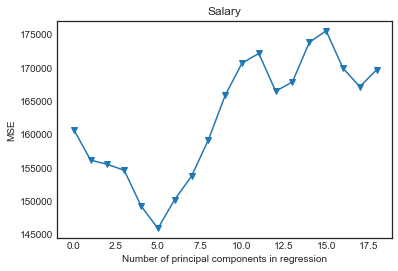

In [64]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

The above plot indicates that the lowest training MSE is reached when doing regression on 6 components.

#### Transform test data with PCA & compute test result

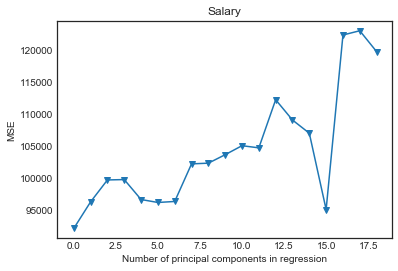

In [53]:
regr = LinearRegression()
mse = []
for i in np.arange(1, 20):
    X_reduced_test = pca2.transform(scale(X_test))[:,:i]
    # Train regression model on training data 
    regr = LinearRegression()
    regr.fit(X_reduced_train[:,:i], y_train)
    # Prediction with test data
    pred = regr.predict(X_reduced_test)
    mse.append(mean_squared_error(y_test, pred)) 

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

### 6.7.2 Partial Least Squares

Scikit-learn PLSRegression gives same results as the pls package in R when using 'method='oscorespls'. In the LAB excercise, the standard method is used which is 'kernelpls'. 

When doing a slightly different fitting in R, the result is close to the one obtained using scikit-learn.

    pls.fit=plsr(Salary~., data=Hitters, subset=train, scale=TRUE, validation="CV", method='oscorespls')
    validationplot(pls.fit,val.type="MSEP", intercept = FALSE)
   
See documentation:
http://scikit-learn.org/dev/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression

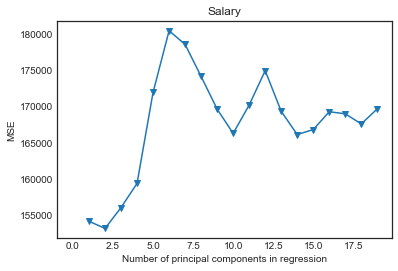

In [54]:
# Select best # of components using CV
n = len(X_train)
mse = []
for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)
    # without cross validation
    #pls.fit(scale(X_train), y_train)
    #pred = pls.predict(X_train)
    #mse.append(mean_squared_error(y_train, pred)) 

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

### Test mse with different # of principal components in regression

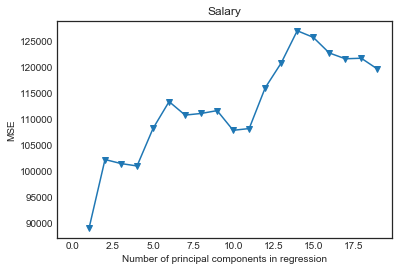

In [55]:

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    pls.fit(scale(X_train), y_train)

    mse.append(mean_squared_error(y_test, pls.predict(scale(X_test))))

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);